# Processing notebook for surge observations

In [1]:
# import libraries needed for the analysis
import numpy as np

# dynamic applications for notebook
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

# local library for the surge observations processing
import process_surgeObs as pso


In [124]:
# reload library - for bugfixing!!
import importlib
importlib.reload(pso)

<module 'process_surgeObs' from '/net/home/h01/frxs/surge_obs/surge_observations_qc/process_surgeObs.py'>

# Step 1: Set up for the analysis

In [51]:
# set up for the analysis

# year and month to be processed
year = '2020'
month = 'jun'

# set dictionaries and initial port index value
portdict = pso.setPorts()
datafornc = pso.setObsDict()
modelfornc = pso.setModelDict()
index = -1

# sets whether we are including model data or not
modelread = True

# Step 2: Load and process the surge obs file data

## 2a. Run the step below to update to the next port

This step loads in the data for QC, visualizes in an interactive plot and pandas Dataframe for the observations, and loads data into dictionaries ready to write out to the netCDF file

Index 39: SEPA-Wick
[INFO] Reading data from ../WIC2020junch1.mdl
[INFO] Reading data from ../WIC2020junch2.mdl
[INFO] Reading data from ../WIC2020jun.mdl
[INO] WIC best data std: 0.21
[INFO] Loading model port residuals data from Met Office monitoring system
[INFO] Plotting port residuals data


<IPython.core.display.Javascript object>


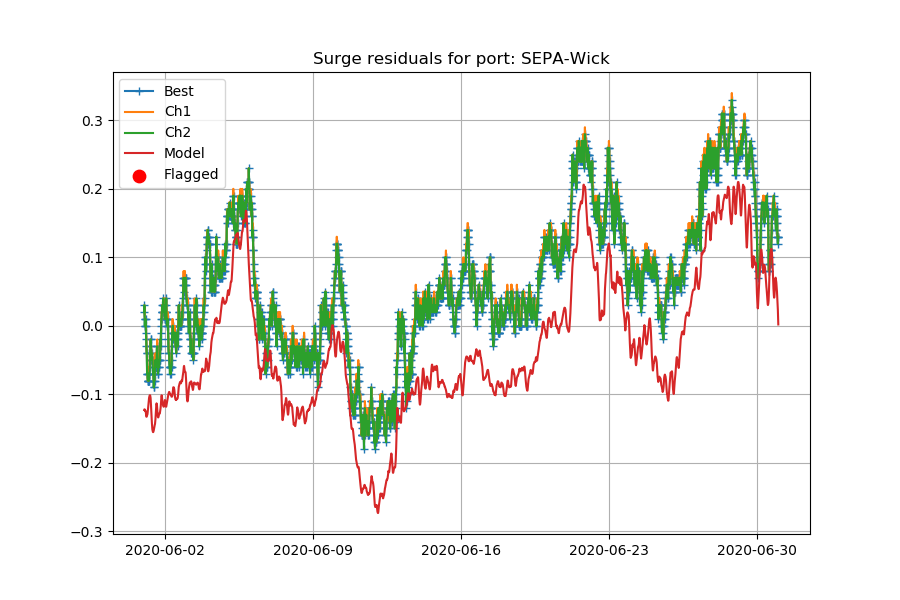

[INFO] Port: SEPA-Wick
[INFO] Creating pandas DataFrame for observations


interactive(children=(IntSlider(value=1500, description='x', max=3000), Output()), _dom_classes=('widget-inter…

[INFO] 40 Ports processed so far
odict_keys(['EA-Avonmouth', 'EA-Bournemouth', 'EA-Cromer', 'EA-Dover', 'EA-Harwich', 'EA-Heysham', 'EA-HinkleyPoint', 'EA-Ilfracombe', 'EA-Immingham', 'EA-Liverpool', 'EA-Lowestoft', 'EA-Newhaven', 'EA-Newlyn', 'EA-NorthShields', 'EA-Plymouth', 'EA-Portsmouth', 'EA-Sheerness', 'EA-StMarys', 'EA-Weymouth', 'EA-Whitby', 'EA-Workington', 'NRW-Barmouth', 'NRW-Fishguard', 'NRW-Holyhead', 'NRW-Llandudno', 'NRW-MilfordHaven', 'NRW-Mumbles', 'NRW-Newport', 'RA-Bangor', 'RA-Portrush', 'SEPA-Aberdeen', 'SEPA-Kinlochbervie', 'SEPA-Leith', 'SEPA-Lerwick', 'SEPA-Millport', 'SEPA-Portpatrick', 'SEPA-Stornoway', 'SEPA-Tobermory', 'SEPA-Ullapool', 'SEPA-Wick'])


In [99]:
# increment the port
index,port = pso.nextPort(index,portdict)
print('Index %d: %s' %(index,port))

# load the port observations and model data
times, channels, flags = pso.loadPortObsNOC(portdict[port]['shortname'], year, month, stdmax=0.8, datadir='..')
if modelread:
    modeltimes,modelresidual,modeltide = pso.loadPortModelMonitoring(portdict[port]['locname'],
                                                                     year, month, 
                                                                     datadir='/data/users/frwave/surge_port_files/uk_det')

if not modelread: modelresidual = None
pso.plotPort(port, year, month, times, channels, model=modelresidual, astro=None,
             plotCh1=True, plotCh2=True, stdmax=1.0)

# set up the interactive pandas dataframe for the obs
print('[INFO] Port: %s' %port)
df = pso.createDataFrame(times,channels,flags)
@interact
def rows_more_than(x=(0,3000)):
    return df.iloc[x:x+20,:]

# add data to dictionaries for write out to netCDF file
datafornc = pso.appendObsDict(datafornc, portdict, port, times, df)
if modelread:
    modelfornc = pso.appendModelDict(modelfornc, portdict, port, times, modelresidual, modeltide)

# check what ports we have done so far
print('[INFO] %d Ports processed so far' %len(datafornc.keys()))
print(datafornc.keys())

## 2b. OPTIONAL - User defines the code to update the dataframe elements

In [92]:
print('Updating Observations DataFrame')

# common task options:
# df = pso.maskBest(df, firstindex, lastindex=None, maskchannel=False)
# df = pso.swapBest(df, chi, firstindex, lastindex=None, maskchannel=False)
# df = pso.maskChannel(df, chi, firstindex, lastindex=None, mask=False)

# jun 2020 hinkley
#df = pso.maskBest(df,0,lastindex=2976)

# jun2020 fishguard
#df = pso.swapBest(df, 2, 433)

#jun2020 mumbles
#df = pso.maskBest(df,2490,lastindex=2492)

#jun2020 lerwick
df = pso.maskBest(df, 0, lastindex=39)


Updating Observations DataFrame


## 2c. OPTIONAL - Reload the corrected observations data to the output dictionary

In [93]:
# need to convert pandas dataframe elements into numpy masked arrays
datafornc = pso.appendObsDict(datafornc, portdict, port, times, df)

# check what ports we have done so far
print(datafornc.keys())

odict_keys(['EA-Avonmouth', 'EA-Bournemouth', 'EA-Cromer', 'EA-Dover', 'EA-Harwich', 'EA-Heysham', 'EA-HinkleyPoint', 'EA-Ilfracombe', 'EA-Immingham', 'EA-Liverpool', 'EA-Lowestoft', 'EA-Newhaven', 'EA-Newlyn', 'EA-NorthShields', 'EA-Plymouth', 'EA-Portsmouth', 'EA-Sheerness', 'EA-StMarys', 'EA-Weymouth', 'EA-Whitby', 'EA-Workington', 'NRW-Barmouth', 'NRW-Fishguard', 'NRW-Holyhead', 'NRW-Llandudno', 'NRW-MilfordHaven', 'NRW-Mumbles', 'NRW-Newport', 'RA-Bangor', 'RA-Portrush', 'SEPA-Aberdeen', 'SEPA-Kinlochbervie', 'SEPA-Leith', 'SEPA-Lerwick'])


# Step 3. Export the data to the netCDF file

In [100]:
# generate netCDF file
if not modelread: modelfornc = None
pso.createSurgeObsnc(datafornc, model=modelfornc, outdir='..')


Writing data to ../test_surgeobs_classa_qc_202006.nc
